In [10]:
from matplotlib import pyplot as plt
import multigrate as mtg
import scanpy as sc

# Load data

In [2]:
# load preprocessed data separately for RNA and ADT modalities from a CITE-seq experiment
adata = sc.read('../../../adata_test.h5ad')
cite = sc.read('../../../cite_test.h5ad')

In [3]:
adata

AnnData object with n_obs × n_vars = 500 × 4000
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'label', 'cell_type'
    var: 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    layers: 'count'

In [4]:
cite

AnnData object with n_obs × n_vars = 500 × 192
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'label', 'cell_type'
    var: 'feature_types'
    uns: 'hvg', 'leiden', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    layers: 'count'

In [5]:
# follow scvi-tools pipeline and register needed data that later will be used in the network
mtg.model.MultiVAE.setup_anndata(
    adatas = [[adata], [cite]],   # list per modality
    groups = [[0], [0]],          # how data is paired
    layers = [['count'], [None]]) # which layers to use

INFO     Using batches from adata.obs["batch_key"]                                           
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["count"]                                               
INFO     Successfully registered anndata object containing 500 cells, 4000 vars, 1 batches, 1
         labels, and 0 proteins. Also registered 2 extra categorical covariates and 1 extra  
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          
INFO     Using batches from adata.obs["batch_key"]                                           
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Successfully registered anndata object containing 5

In [6]:
model = mtg.model.MultiVAE(
    adatas = [[adata], [cite]], # same as above
    condition = True,           # whether to do batch correction (not important here as just 1 batch)
    losses = ['nb', 'mse'])     # losses for the decoder: if using raw counts, use NB or ZINB

In [7]:
model.train(n_iters=1000)

 |████████████████████| 100.0% iter=1000/1000, time=7.09(s), loss=0.1282, recon=0.1282, kl=19.5199, integ=0.0000, cycle=0.0000, val_loss=0.1204, val_recon=0.1204, val_kl=17.4227, val_integ=0.0000, val_cycle=0.0000

In [8]:
model.history

,iteration,train_loss,train_recon,train_recon_mse,train_recon_nb,train_recon_zinb,train_recon_bce,train_kl,train_integ,train_cycle,val_loss,val_recon,val_recon_mse,val_recon_nb,val_kl,val_integ,val_cycle
0,100,0.392392,0.392392,0.280762,0.111629,0.0,0.0,7.258546,0.0,0.0,0.266604,0.266604,0.158635,0.107970,8.351567,0,0
1,200,0.217541,0.217541,0.121519,0.096022,0.0,0.0,11.049209,0.0,0.0,0.165898,0.165898,0.073202,0.092696,11.547140,0,0
2,300,0.163523,0.163523,0.078591,0.084932,0.0,0.0,13.821050,0.0,0.0,0.137862,0.137862,0.054332,0.083531,13.829823,0,0
3,400,0.145862,0.145862,0.067935,0.077927,0.0,0.0,15.297878,0.0,0.0,0.130036,0.130036,0.051491,0.078545,15.292768,0,0
4,500,0.138935,0.138935,0.065694,0.073241,0.0,0.0,17.207799,0.0,0.0,0.125434,0.125434,0.049804,0.075630,16.436054,0,0
5,600,0.135638,0.135638,0.062730,0.072908,0.0,0.0,18.404066,0.0,0.0,0.123418,0.123418,0.049352,0.074067,17.358007,0,0
6,700,0.133682,0.133682,0.061009,0.072673,0.0,0.0,18.754626,0.0,0.0,0.122520,0.122520,0.049299,0.073221,18.139862,0,0
7,800,0.128191,0.128191,0.058635,0.069556,0.0,0.0,19.609367,0.0,0.0,0.121411,0.121411,0.048782,0.072629,18.735868,0,0
8,900,0.127786,0.127786,0.057775,0.070012,0.0,0.0,20.519946,0.0,0.0,0.121095,0.121095,0.048762,0.072333,18.970102,0,0
9,999,0.128155,0.128155,0.057039,0.071117,0.0,0.0,19.519910,0.0,0.0,0.120381,0.120381,0.048320,0.072061,17.422663,0,0


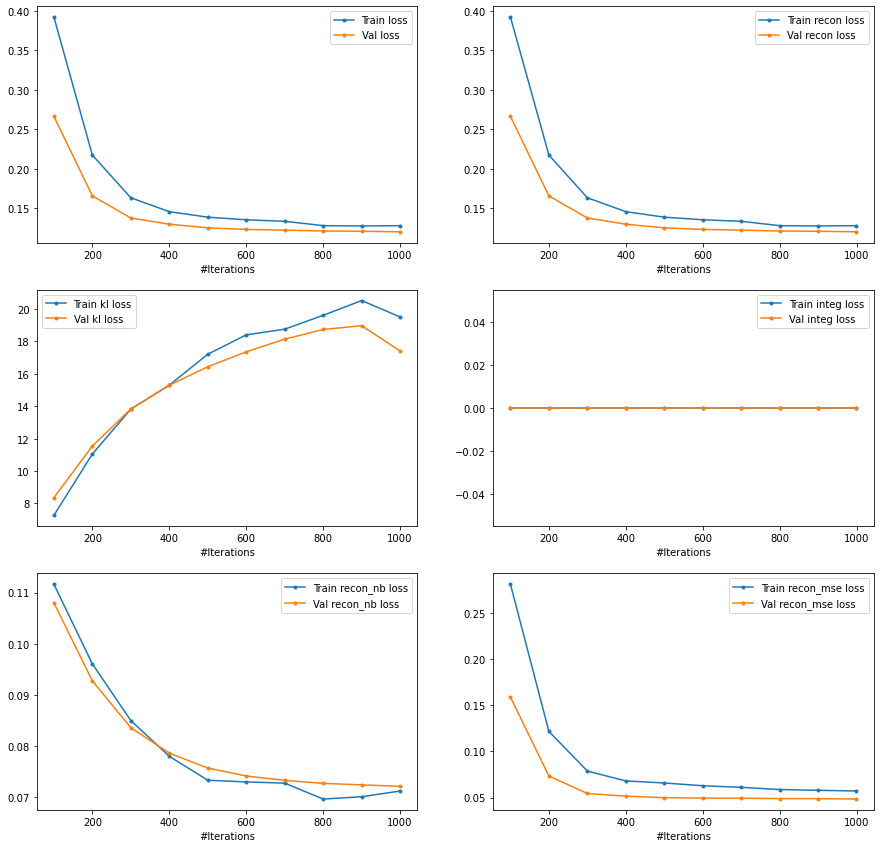

In [11]:
plt.figure(figsize=(15, 20));
loss_names = ['recon', 'kl', 'integ', 'recon_nb', 'recon_mse'] # recon_mse
nrows = 4

plt.subplot(nrows, 2, 1)
plt.plot(model.history['iteration'], model.history['train_loss'], '.-', label='Train loss');
plt.plot(model.history['iteration'], model.history['val_loss'], '.-', label='Val loss');
plt.xlabel('#Iterations');
plt.legend()

for i, name in enumerate(loss_names):
    plt.subplot(nrows, 2, i+2)
    plt.plot(model.history['iteration'], model.history[f'train_{name}'], '.-', label=f'Train {name} loss');
    plt.plot(model.history['iteration'], model.history[f'val_{name}'], '.-', label=f'Val {name} loss');
    plt.xlabel('#Iterations');
    plt.legend()

In [12]:
model.get_latent_representation() # modifies adatas in-place

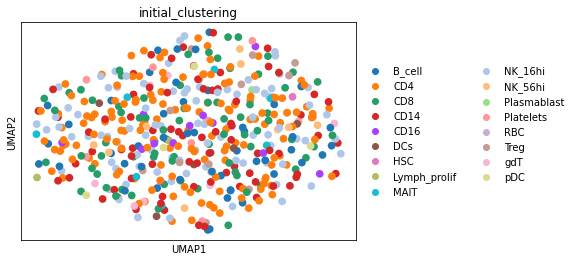

In [13]:
sc.pp.neighbors(adata, use_rep="latent")
sc.tl.umap(adata)
sc.pl.umap(adata, color='initial_clustering')